# CaloriePhone: food-to-calorie translation

TODO description

# Libraries and constants


In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import keras.utils
import sklearn.preprocessing
from matplotlib import pyplot as plt
from PIL import Image as pil_image

import getpass
import logging
import time
import requests
import json
import urllib.request
import shutil
import random

2022-06-07 23:57:37.751958: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
tf.__version__
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


2022-06-07 23:57:41.090415: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-07 23:57:41.143181: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-07 23:57:41.143379: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


We will be using `InceptionResNetV2` as out base model for transfer learning (this will be explained later in-depth). For now, we define the `IMG_SIZE` to be 299x299, the resolution this model expects.

In [3]:
# InceptionResNetV2 accepts 299x299 images as input
IMG_SIZE = (299, 299)
IMG_SHAPE = IMG_SIZE + (3,)
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2
MOUNT_PATH = '/mnt/drive'
# DATA_DIR = '/mnt/drive/MyDrive/caloriephone/data'
DATA_DIR = '/home/vlad/Downloads/test/data'

# mount drive
# from google.colab import drive
# drive.mount(MOUNT_PATH)

# Experiment 1: Dynamic dataset

## Data Preprocessing


Besides building the classificator, we need to know how many calories each kind of food contains. We will be using the `vaishnavivenkatesan/food-and-their-calories` dataset which is a CSV file of different foods and the appropriate amount of calories in a single serving of each.

In [4]:
# we will need to download the mapping from kaggle datasets
# let's make sure kaggle cli is installed
!python3 -m pip install kaggle

# get log-in credentials
# get credentials from https://www.kaggle.com -> click on your username on the right -> "Account" in the middle bar -> "Create New API Token" 
os.environ["KAGGLE_USERNAME"] = input("Kaggle username: ")
os.environ["KAGGLE_KEY"] = getpass.getpass("Kaggle key: " )

# download mapping
!kaggle datasets download --unzip vaishnavivenkatesan/food-and-their-calories

  0%|                                               | 0.00/6.59k [00:00<?, ?B/s]
100%|██████████████████████████████████████| 6.59k/6.59k [00:00<00:00, 3.00MB/s]


In [4]:
# read food to calorie mapping CSV
mapping_csv = pd.read_csv("Food and Calories - Sheet1.csv")
mapping_csv.head()

,Food,Serving,Calories
0,Artichoke,1 artichoke (128 g),60 cal
1,Arugula,1 leaf (2 g),1 cal
2,Asparagus,1 spear (12 g),2 cal
3,Aubergine,1 aubergine (458 g),115 cal
4,Beetroot,1 beet (82 g),35 cal


Let's see how many food types there are in this CSV:

In [5]:
# each food type is a row
# thus amount of rows is indicative of the amount of possible classes
print(mapping_csv.shape[0])

562


For some reason, the provided CSV contains duplicates of some foods. Let's filter them out.

In [6]:
mapping_csv.drop_duplicates(subset=['Food'], inplace=True)
print(mapping_csv.shape[0])

541


Some of the classes found in this CSV are extremely specific. They include classes such as:

- Big N' Tasty (commercial name for a McDonald's burger)
- Burger King Angry Whopper (also a commercial name, not an actual food type)
- Alphabet Soup	(a soup that has letter shaped pasta in it)

We aim to classify different food types, as opposed to specific foods, so we have decided to filter out some of the classes.

In [7]:
# define a blacklist of foods
food_class_blacklist = []
with open('food_class_blacklist.json', 'r') as food_class_blacklist_file:
  food_class_blacklist = json.loads(food_class_blacklist_file.read())

# filter CSV
mapping_csv.drop(mapping_csv[mapping_csv["Food"].isin(food_class_blacklist)].index, inplace=True)

Let's see the amount of classes we are left with:

In [8]:
# each food type is a row
# thus amount of rows is indicative of the amount of possible classes
CLASSES_AMOUNT = mapping_csv.shape[0]
print(CLASSES_AMOUNT)

98


Now that we have the filtered CSV we need, we can start downloading our data. The following automation queries Unsplash image search API for images and stores them in appropriate train and test directories.

The initial run of the script will take a while because of bandwidth, latency and rate limiting issues.

- a free Unsplash account is allowed to query search API 50 times an hour - meaning 50 searches, each one with 30 results (images). So:
  - in an hour, we can only download 30 * 50 = 1500 images
  - given that we are dealing with 322 classes with 90 images per class (worst case), (322 * 90) / (30 * 50) = ~19 hours in total
- if the notebook is being executed on a local machine, the bandwidth + latency issues come into play. These can be solved by running the script through Google Colab since a virtual machine is being provisioned for execution which is located in a data center. Chances are, this virtual machine is much closer to Unsplash servers than we are. 

The script skips download of a class if a directory for that class is already present, therefore a second run barely takes time since it does not query the API or download anything.

In [10]:
RATE_LIMIT_TIMEOUT_SECONDS = 3720
IMAGE_FORMAT = "jpg"
PAGES_PER_CLASS = 3 # each page gets you 30 images
TEST_SPLIT = 0.2

def query_unsplash_api(url, params, client_id):

    logging.info(f"qeurying API at {url} with params {params} ...")

    rate_limit_reached = False
    response_received = False

    # query api until a response is received
    while not response_received:

      try:

          # query api
          response = requests.get(url, params=params, timeout=60, headers={
              "Accept-Version": "v1",
              "Authorization": f"Client-ID {client_id}"
          })
          response.raise_for_status()

      except requests.HTTPError as e:

          # 403 - rate limit reached
          if e.response.status_code == 403:
            rate_limit_reached = True
          else:
            raise e

      # if HTTP status code is valid - response received
      else:
          response_received = True

      # handle rate limit reached
      if rate_limit_reached or ( response_received and int(response.headers["X-Ratelimit-Remaining"]) == 0 ):
          logging.info(f"rate limit reached, sleeping for {RATE_LIMIT_TIMEOUT_SECONDS} seconds...")
          time.sleep(RATE_LIMIT_TIMEOUT_SECONDS)

    # log remaining rate limit
    logging.info(f"X-Ratelimit-Remaining: {response.headers['X-Ratelimit-Remaining']}")

    return response

def download_data():

    # parse arguments
    CLIENT_ID = getpass.getpass("unsplash.com client ID: ")

    # set-up logger
    logging.basicConfig(level=logging.INFO, format='[%(asctime)s] %(message)s')

    # for each food
    for _, row in mapping_csv.iterrows():

        # get food and serving fields
        food = row['Food'].strip()
        food_train_path = f"{DATA_DIR}/train/{food}"
        food_test_path = f"{DATA_DIR}/test/{food}"

        # download images only if directory is not yet present
        if os.path.exists(food_train_path):
            
            logging.info(f"'{food_train_path}' already exists, skipping")

        else:

            # initiate food train directory
            os.makedirs(food_train_path)

            # init downloaded image list
            image_names = []

            # iterate result pages
            for page_index in range(PAGES_PER_CLASS):

              # query api for images
              search_response = json.loads(query_unsplash_api("https://api.unsplash.com/search/photos", params={
                  "query": f"{food}",
                  "page": f"{page_index + 1}",
                  "per_page": "30"
              }, client_id=CLIENT_ID).text)

              # iterate search results
              for image in search_response["results"]:

                  # download image
                  image_url = f'{image["urls"]["raw"]}&crop=entropy&w={IMG_SIZE[0]}&h={IMG_SIZE[1]}&fm={IMAGE_FORMAT}'
                  image_path = f"{food_train_path}/{image['id']}.{IMAGE_FORMAT}"
                  logging.info(f"downloading image for '{food}' at {image_url} ...")
                  urllib.request.urlretrieve(image_url, image_path)
                  image_names.append(os.path.basename(image_path))

            # clear food test directory
            if os.path.exists(food_test_path):
              shutil.rmtree(food_test_path)
            os.makedirs(food_test_path)

            # iterate test split
            for image_name_index in range(int(len(image_names) * TEST_SPLIT)):

              # move image to test set
              image_src_path = f"{food_train_path}/{image_names[image_name_index]}"
              image_dst_path = f"{food_test_path}/{image_names[image_name_index]}"
              logging.info(f"moving '{food}' image at {image_src_path} to {image_dst_path}")
              os.rename(image_src_path, image_dst_path)            

# start download process
download_data()

[2022-06-06 12:28:24,577] '/home/vlad/Downloads/test/data/train/Artichoke' already exists, skipping
[2022-06-06 12:28:24,578] '/home/vlad/Downloads/test/data/train/Arugula' already exists, skipping
[2022-06-06 12:28:24,579] '/home/vlad/Downloads/test/data/train/Asparagus' already exists, skipping
[2022-06-06 12:28:24,580] '/home/vlad/Downloads/test/data/train/Aubergine' already exists, skipping
[2022-06-06 12:28:24,581] '/home/vlad/Downloads/test/data/train/Broccoli' already exists, skipping
[2022-06-06 12:28:24,582] '/home/vlad/Downloads/test/data/train/Cabbage' already exists, skipping
[2022-06-06 12:28:24,582] '/home/vlad/Downloads/test/data/train/Carrot' already exists, skipping
[2022-06-06 12:28:24,582] '/home/vlad/Downloads/test/data/train/Cauliflower' already exists, skipping
[2022-06-06 12:28:24,583] '/home/vlad/Downloads/test/data/train/Celery' already exists, skipping
[2022-06-06 12:28:24,583] '/home/vlad/Downloads/test/data/train/Chives' already exists, skipping
[2022-06-06 

Now that the data is present - we can load our training, validation and testing sets and begin construction of our network!

In [9]:
# read entire dataset and split to train, validation and test sets
training_set = tf.keras.utils.image_dataset_from_directory( f"{DATA_DIR}/train",
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE,
                                                            label_mode='categorical',
                                                            validation_split=VALIDATION_SPLIT,
                                                            seed=42,
                                                            subset='training')

validation_set = tf.keras.utils.image_dataset_from_directory(   f"{DATA_DIR}/train",
                                                                shuffle=True,
                                                                batch_size=BATCH_SIZE,
                                                                image_size=IMG_SIZE,
                                                                label_mode='categorical',
                                                                validation_split=VALIDATION_SPLIT,
                                                                seed=42,
                                                                subset='validation')

test_set = tf.keras.utils.image_dataset_from_directory( f"{DATA_DIR}/test",
                                                        shuffle=True,
                                                        batch_size=BATCH_SIZE,
                                                        image_size=IMG_SIZE,
                                                        label_mode='categorical')

Found 6322 files belonging to 98 classes.
Using 5058 files for training.


2022-06-07 23:57:57.109942: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-07 23:57:57.112109: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-07 23:57:57.112277: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-07 23:57:57.112398: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA

Found 6322 files belonging to 98 classes.
Using 1264 files for validation.
Found 1659 files belonging to 98 classes.


The code below will enable buffer prefetching or all sets. This setting will let images load from disk without encountering I/O blocking, making the data streaming process faster.

In [10]:
training_set = training_set.prefetch(buffer_size=tf.data.AUTOTUNE)
validation_set = validation_set.prefetch(buffer_size=tf.data.AUTOTUNE)
test_set = test_set.prefetch(buffer_size=tf.data.AUTOTUNE)

## Building the CNN

We will use transfer learning, a technique which uses a pre-trained model, to achieve good results. The model we are going to use is called `InceptionResNetV2`, which has proven itself to work very well with classification in our previous exercises.

In [11]:
# use InceptionResNet2 as base model
base_model_function = tf.keras.applications.InceptionResNetV2
base_model_preprocess_input = tf.keras.applications.inception_resnet_v2.preprocess_input
base_model_decode_predictions = tf.keras.applications.inception_resnet_v2.decode_predictions

In [12]:
# init base model
base_model = base_model_function(   input_shape=IMG_SHAPE,
                                    include_top=False,
                                    weights='imagenet')

# freeze base layers
base_model.trainable = False

Data augmentation is a good idea in our case for the following reasons:
- food can be pictured from a variety of angles
- we are dealing with a relatively small dataset

In [13]:
# init base layer with augmentations
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

Here's a preview of how this augmentation affects our images: 

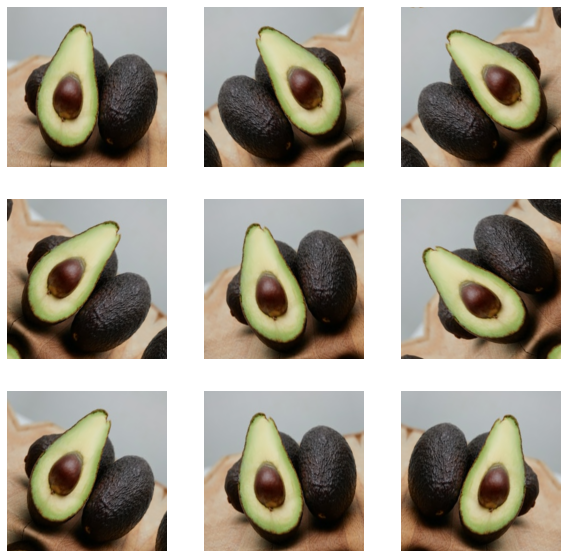

In [14]:
# take single batch
for image, _ in training_set.take(1):

  # prepare plot
  plt.figure(figsize=(10, 10))

  # take first image from batch
  first_image = image[0]

  # display 9 different augmentations of image
  for i in range(9):
    
    axis = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0), training=True)
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

After passing an image through our base model, we will need to generate predictions from returned block of features. This `GlobalAveragePooling2D` layer will convert these features to a single vector.

In [15]:
# convert to vectors for feature extraction 
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

Finally, the prediction layer is needed for our model's output. Each unit in this `Dense` layer accounts for a class.  

In [16]:
# dense layer of unit per class
prediction_layer = tf.keras.layers.Dense(   units=CLASSES_AMOUNT,
                                            activation=tf.keras.activations.softmax)

Let's combine our model using the following layers:
- input layer with the shape representing our image resolution
- augmentation layer for those images
- preprocess layer so images can be fed to the base model
- `InceptionResNetV2` layers
- `GlobalAveragePooling2D` to convert the feature map
- `Dropout` layer for good measure
- prediction layer so results can be read from the base model

In [17]:
# build model 
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = base_model_preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

# show summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 299, 299, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 299, 299, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 299, 299, 3)      0         
 a)                                                              
                                                                 
 inception_resnet_v2 (Functi  (None, 8, 8, 1536)       54336736  
 onal)                                                           
                                                             

## Training the model

The model will now be trained to classify foods based on our classes.

In [18]:
model.compile(  optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                loss=tf.keras.losses.MeanSquaredError(),
                metrics=['accuracy'])
                
model.evaluate(validation_set)

2022-06-07 14:42:38.614725: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8201
2022-06-07 14:42:39.170310: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-06-07 14:42:39.171023: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2022-06-07 14:42:39.171029: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2022-06-07 14:42:39.171053: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be 

 1/40 [..............................] - ETA: 3:17 - loss: 0.0102 - accuracy: 0.0000e+00

2022-06-07 14:42:41.299464: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


40/40 [==============================] - 15s 248ms/step - loss: 0.0101 - accuracy: 0.0119


[0.010144195519387722, 0.01186708826571703]

In [ ]:
history = model.fit(training_set,
                    epochs=10,
                    validation_data=validation_set)

## Visualization of Loss and Accuracy

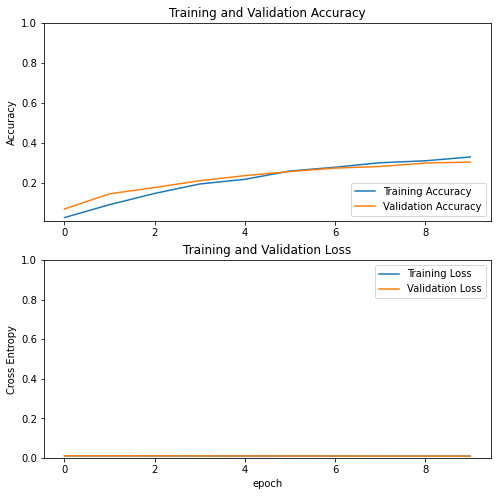

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Model evaluation

In [22]:
model.evaluate(test_set)

52/52 [==============================] - 13s 250ms/step - loss: 0.0088 - accuracy: 0.2682


[0.008813995867967606, 0.26823386549949646]

TODO explain why this is bad

# Experiment 2: A more mature dataset

## Data preprocessing

In [23]:
!kaggle datasets download dansbecker/food-101
!unzip -n food-101.zip

food-101.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  food-101.zip


In [18]:
DATA_DIR = 'food-101/food-101/images/'
CLASSES_AMOUNT = 101

In [19]:
# read entire dataset and split to train, validation and test sets
training_set = tf.keras.utils.image_dataset_from_directory( f"{DATA_DIR}",
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE,
                                                            label_mode='categorical',
                                                            validation_split=VALIDATION_SPLIT,
                                                            seed=42,
                                                            subset='training')

validation_set = tf.keras.utils.image_dataset_from_directory(   f"{DATA_DIR}",
                                                                shuffle=True,
                                                                batch_size=BATCH_SIZE,
                                                                image_size=IMG_SIZE,
                                                                label_mode='categorical',
                                                                validation_split=VALIDATION_SPLIT,
                                                                seed=42,
                                                                subset='validation')

# test_set = tf.keras.utils.image_dataset_from_directory( f"{DATA_DIR}/validation",
#                                                         shuffle=True,
#                                                         batch_size=BATCH_SIZE,
#                                                         image_size=IMG_SIZE,
#                                                         label_mode='categorical')

Found 101000 files belonging to 101 classes.
Using 80800 files for training.
Found 101000 files belonging to 101 classes.
Using 20200 files for validation.


In [20]:
training_set = training_set.prefetch(buffer_size=tf.data.AUTOTUNE)
validation_set = validation_set.prefetch(buffer_size=tf.data.AUTOTUNE)

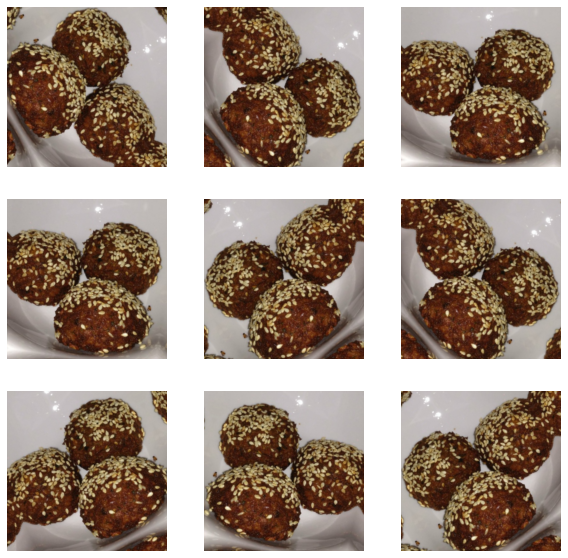

In [21]:
# take single batch
for image, _ in training_set.take(1):

  # prepare plot
  plt.figure(figsize=(10, 10))

  # take first image from batch
  first_image = image[0]

  # display 9 different augmentations of image
  for i in range(9):
    
    axis = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0), training=True)
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

## Building the CNN

Prediction layer is the exact same, but the amount of classes has changed.

In [22]:
prediction_layer = tf.keras.layers.Dense(   units=CLASSES_AMOUNT,
                                            activation=tf.keras.activations.softmax)

In [23]:
# reassemble model 
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = base_model_preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

# show summary
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 299, 299, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 299, 299, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 299, 299, 3)      0         
 bda)                                                            
                                                                 
 inception_resnet_v2 (Functi  (None, 8, 8, 1536)       54336736  
 onal)                                                           
                                                           

In [ ]:
model.compile(  optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                loss=tf.keras.losses.MeanSquaredError(),
                metrics=['accuracy'])

history = model.fit(training_set,
                    epochs=10,
                    validation_data=validation_set)

# Experiment 3: Multi-label classifier

Suppose this model can classify a single food type from a single image, but that is not enough. Our goal is to be able to classify all kinds of foods that are present in the picture - a plate of food, for instance.

An approach to building a multi-label classifier will be a little different.

## Data preprocessing

In [24]:
# in this script, we are going to create X_train, X_val, y_train, y_val of data
# where 'X' is paths to food images and 'y' is a list of just one item - its label (class)

data_tuples = []

# iterate food types
for food_type in os.listdir(DATA_DIR):
    
    food_type_path = os.path.join(DATA_DIR, food_type)

    if (os.path.isdir(food_type_path)):

        # iterate food images
        for food_image_name in os.listdir(food_type_path):
            data_tuples.append((os.path.join(food_type_path, food_image_name), [food_type]))

# shuffle list for randomness
random.shuffle(data_tuples)

# split to train and validation
split_index = int(len(data_tuples) * (1 - VALIDATION_SPLIT))
train_tuples = data_tuples[:split_index]
val_tuples = data_tuples[split_index:]

print(f"Using {len(train_tuples)} files for training.")
print(f"Using {len(val_tuples)} files for validation.")

# unpack train and validation
X_train, y_train = zip(*train_tuples)
X_val, y_val = zip(*train_tuples)

# cast to lists instead of tuples
X_train = list(X_train)
y_train = list(y_train)
X_val = list(X_val)
y_val = list(y_val)

Using 80800 files for training.
Using 20200 files for validation.


Here is how our input to the multilabel classifier looks:

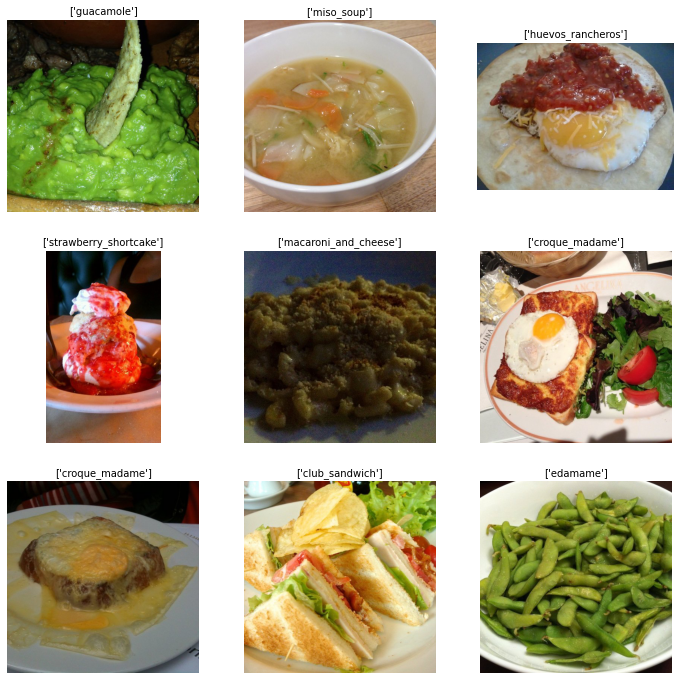

In [25]:
# prepare plot dimensions
n_images = 9
n_columns = 3
n_rows = n_images // n_columns

# display plot of images and their respective labels
plt.figure(figsize=(12,4*n_rows))
for i in range(n_rows * n_columns):

    axis = plt.subplot(n_rows, n_columns, i+1)
    plt.imshow(pil_image.open(X_train[i]))
    plt.title(y_train[i], size=10)
    plt.axis('off')

We will now need to encode our labels so the NN can understand it. We will need to one-hot encdode them - instead of using a plain text to represent a label, we will use set 'bits' in a list.

In [26]:
# MultiLabelBinarizer class lets use one-hot encode labels easily
mlb = sklearn.preprocessing.MultiLabelBinarizer()
mlb.fit(y_train)

# encode labels
y_train_encoded = mlb.transform(y_train)
y_val_encoded = mlb.transform(y_val)

# print encoded representation
for (index, label) in enumerate(mlb.classes_):
    print(f"{index} {label}")

101
0 apple_pie
1 baby_back_ribs
2 baklava
3 beef_carpaccio
4 beef_tartare
5 beet_salad
6 beignets
7 bibimbap
8 bread_pudding
9 breakfast_burrito
10 bruschetta
11 caesar_salad
12 cannoli
13 caprese_salad
14 carrot_cake
15 ceviche
16 cheese_plate
17 cheesecake
18 chicken_curry
19 chicken_quesadilla
20 chicken_wings
21 chocolate_cake
22 chocolate_mousse
23 churros
24 clam_chowder
25 club_sandwich
26 crab_cakes
27 creme_brulee
28 croque_madame
29 cup_cakes
30 deviled_eggs
31 donuts
32 dumplings
33 edamame
34 eggs_benedict
35 escargots
36 falafel
37 filet_mignon
38 fish_and_chips
39 foie_gras
40 french_fries
41 french_onion_soup
42 french_toast
43 fried_calamari
44 fried_rice
45 frozen_yogurt
46 garlic_bread
47 gnocchi
48 greek_salad
49 grilled_cheese_sandwich
50 grilled_salmon
51 guacamole
52 gyoza
53 hamburger
54 hot_and_sour_soup
55 hot_dog
56 huevos_rancheros
57 hummus
58 ice_cream
59 lasagna
60 lobster_bisque
61 lobster_roll_sandwich
62 macaroni_and_cheese
63 macarons
64 miso_soup
65 

TODO explain F1 score

In [28]:
BATCH_SIZE = 256
BUFFER_SIZE = 512

In [29]:
def parse_data(filename, label):

    # read image bytes
    image_bytes = tf.io.read_file(filename)

    # read as jpeg
    image_decoded = tf.image.decode_jpeg(image_bytes, channels=3)

    # resize image
    image_resized = tf.image.resize(image_decoded, [IMG_SIZE[0], IMG_SIZE[1]])

    return image_resized, label

def parse_dataset(filenames, labels, is_training=True):
    
    # init dataset
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))

    # parse data using parse function
    dataset = dataset.map(parse_data, num_parallel_calls=tf.data.AUTOTUNE)
    
    if is_training == True:

        # shuffle data
        dataset = dataset.shuffle(buffer_size=BUFFER_SIZE)
        
    # batch data
    dataset = dataset.batch(BATCH_SIZE)

    # prefetch from disk
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    
    return dataset

In [30]:
training_set = parse_dataset(X_train, y_train_encoded)
validation_set = parse_dataset(X_val, y_val_encoded)

TODO explain element spec

In [31]:
print(training_set.element_spec)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 101), dtype=tf.int64, name=None))>


#### F1 score loss function

TODO explain

In [33]:
@tf.function
def f1_score_loss(label_tensor, matrix_tensor):

    # cast to float32 as we are dealing with float values
    label_tensor = tf.cast(label_tensor, tf.float32)
    matrix_tensor = tf.cast(matrix_tensor, tf.float32)

    # calculate confusion matrix values
    # - TP: true positive
    # - FP: false positive
    # - FN: true negative
    TP = tf.reduce_sum(matrix_tensor * label_tensor, axis=0)
    FP = tf.reduce_sum(matrix_tensor * (1 - label_tensor), axis=0)
    FN = tf.reduce_sum((1 - matrix_tensor) * label_tensor, axis=0)

    # use F1 score formula to calculate F1 score
    f1 = (2*TP) / (2*TP + FN + FP + 1e-16)

    # deduce cost from calculated F1 score
    cost = 1 - f1

    # deduce average across all labels
    avg_cost = tf.reduce_mean(cost)
    return avg_cost

@tf.function
def f1_score_metric(label_tensor, matrix_tensor, thresh=0.1):

    # get prediction if greater than threshold
    label_tensor_filtered = tf.greater(matrix_tensor, thresh)

    # cast to float32 as we are dealing with float values
    label_tensor_prediction = tf.cast(label_tensor_filtered, tf.float32)
    matrix_tensor = tf.cast(matrix_tensor, tf.float32)

    # calculate confusion matrix values
    # - TP: true positive
    # - FP: false positive
    # - FN: true negative
    TP = tf.cast(tf.math.count_nonzero(label_tensor_prediction * label_tensor, axis=0), tf.float32)
    FP = tf.cast(tf.math.count_nonzero(label_tensor_prediction * (1 - label_tensor), axis=0), tf.float32)
    FN = tf.cast(tf.math.count_nonzero((1 - label_tensor_prediction) * label_tensor, axis=0), tf.float32)

    # use F1 score formula to calculate F1 score for current batch
    f1 = (2*TP) / (2*TP + FN + FP + 1e-16)

    # deduce average across all labels for current batch
    f1 = tf.reduce_mean(f1)

    return f1

## Building multi-label classifier CNN

TODO explain why sigmoid

In [34]:
prediction_layer = tf.keras.layers.Dense(   CLASSES_AMOUNT,
                                            activation=tf.keras.activations.sigmoid,
                                            name='prediction')

In [35]:
# reassemble model 
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = base_model_preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

# show summary
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 299, 299, 3)       0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 299, 299, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_2 (TFOpLam  (None, 299, 299, 3)      0         
 bda)                                                            
                                                                 
 inception_resnet_v2 (Functi  (None, 8, 8, 1536)       54336736  
 onal)                                                           
                                                           

## Training the model

In [ ]:
model.compile(  optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                loss=f1_score_loss,
                metrics=[f1_score_metric])

history = model.fit(training_set,
                    epochs=15,
                    validation_data=validation_set)

## Visualization of Loss and Accuracy

TODO

## Some predictions

Here we will define a helper prediction function which will process the image and display predictions. We will use the function to quickly display some test images and their predicted labels.

In [62]:
PREDICTION_CUTOFF = 0.25

def predict(image_path, image_labels):

    # read image as model input
    image = keras.utils.load_img(image_path, target_size=IMG_SHAPE)
    image = keras.utils.img_to_array(image)
    image = np.expand_dims(image, axis=0)

    # predict image labels
    prediction = (model.predict(image) > PREDICTION_CUTOFF).astype('int')
    prediction = pd.Series(prediction[0])
    prediction.index = mlb.classes_
    prediction = prediction[prediction==1].index.values

    # display image and prediction
    plt.figure(figsize=(8,4))
    plt.axis('off')
    plt.imshow(pil_image.open(image_path))
    plt.title(f"\nActual labels:\n{image_labels}\n\nPredicted labels:\n{list(prediction)}\n")
    plt.show()

1/1 [==============================] - 0s 47ms/step


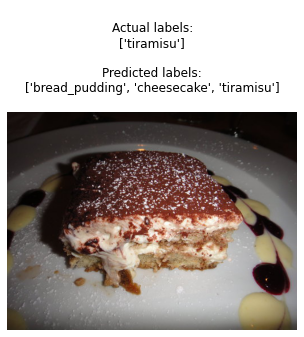

1/1 [==============================] - 0s 20ms/step


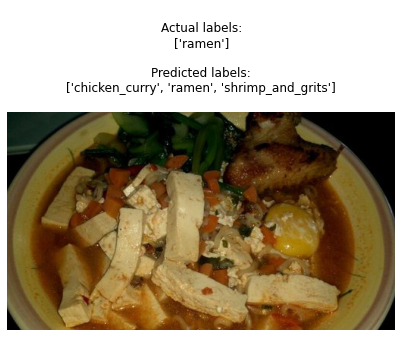

1/1 [==============================] - 0s 41ms/step


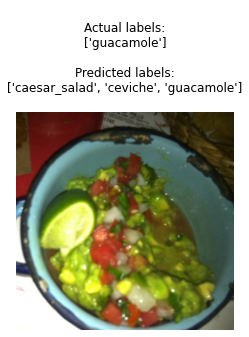

In [63]:
for (test_image_path, test_image_labels) in [
    ("food-101/food-101/images/tiramisu/958418.jpg", ["tiramisu"]),
    ("food-101/food-101/images/ramen/726528.jpg", ["ramen"]),
    ("food-101/food-101/images/guacamole/778243.jpg", ["guacamole"])
]:
    predict(test_image_path, test_image_labels)